In [23]:
from project_lib import *
import itertools
import tqdm

In [2]:
df = pd.read_csv('dataset_tmc.csv', parse_dates = ['Dates'], date_format = '%d/%m/%y')
df.columns = [i.lower() for i in df.columns]
df.columns = [i.replace(' ','_') for i in df.columns]
df = df.set_index('dates')

# Check NaNs
if df.isna().sum().sum() != 0:
    print('check NaNs in data')

# Drop Sat&Sun if any
df = df[df.index.dayofweek<5]

In [3]:
# STRATEGY PARAMETERS
TRADED_SECURITIES = [
            'us_staples',
                'eu_healthcare', 'japan', 'brazil', 'nasdaq', 'us_2y',
                'us_15y', 'germany_10y', 'uk_15y', 'us_hy', 'oil', 'ind_metals', 'agri',
                'gold', 'silver', 'eurusd', 'usdjpy', 'chfjpy', 'eurbrl', 'gbpmxn'
    ]

LONG_PARAMS = {10:0.05, 21:0.15, 63:0.25} # dict with lenght of window as key and percentile for longs as values
SHORT_PARAMS = {10:0.95, 21:0.85, 63:0.75} # dict with lenght of window as key and percentile for shorts as values
MA_FAST_WDW = 20
MA_SLOW_WDW = 60

SUPPORTIVE_PCTL_MOVE = 0.3
COUNTER_PCTL_MOVE = 0.2
TRADES_MAX_DAYS = 21

MAX_DOLLAR_LOSS = 100


SIGMA_WDW = 63
GAMMA = None

In [62]:
def run_bt_pipeline(TRADED_SECURITIES,
            LONG_PARAMS,
            SHORT_PARAMS,
            MA_FAST_WDW,
            MA_SLOW_WDW,
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            ):
    """
    Run BT pipeline
    """


    # list to store all trades
    trades_list = []
    trades_pnl = {}

    for security_id in tqdm.tqdm(TRADED_SECURITIES):
        # generate signal based on standard strategy
        signal_all = meanrev_signal(df[security_id],
                                    long_params = LONG_PARAMS,
                                    short_params = SHORT_PARAMS,
                                    ma_fast_wdw = MA_FAST_WDW,
                                    ma_slow_wdw = MA_SLOW_WDW
                    )
        
        # compute Historical Volatility
        hist_vol = df[security_id].pct_change().rolling(SIGMA_WDW).std() * np.sqrt(252)

        # "start your backtest at t-10". hard coding initial date for BT (and final date to avoid missing data)
        signal_all = signal_all.loc['2014-02-12':'2024-01-20']

        # extract from all signal only the actual open buy/sell triggers
        signal_do = signal_all[signal_all!= 0]

        # iterates over all buy/sell signal and execute orders
        for dt_open, direction in zip(signal_do.index, signal_do):
            
            # create a unique id for each trade
            trade_id = security_id+'#'+str(dt_open)[:10]

            # price at which the trade is open
            price_open = df.loc[dt_open, security_id]

            # compute TP/SL returns and prices
            tp_return, sl_return = tp_sl_rule(df[security_id],
                                                dt_open,
                                                direction,
                                                supportive_pctl_move = SUPPORTIVE_PCTL_MOVE,
                                                counter_pctl_move = COUNTER_PCTL_MOVE
                                            )
            price_tp = price_open * (1 + tp_return*direction)
            price_sl = price_open * (1 + sl_return*direction)

            if GAMMA == None:
                # compute the optimal sizing such that all trades loses the same amount of $ if SL is hitted
                quantity = MAX_DOLLAR_LOSS/((price_open - price_sl)*direction)
            else:
                quantity = MAX_DOLLAR_LOSS/((price_open - price_sl)*direction) * (GAMMA/hist_vol.loc[dt_open])

            # store all trade info in df
            trade = pd.DataFrame({'security_id':security_id,
                                    'dt_open':str(dt_open)[:10],
                                    'price_open':price_open,
                                    'direction':direction,
                                    'quantity':quantity,
                                    'price_tp':price_tp,
                                    'price_sl':price_sl}, index=[trade_id])

            # create a temporary df that contains prices of instrument during trade
            dt_open_idxdf = list(df.index).index(dt_open)
            temp_px = df[[security_id]].iloc[dt_open_idxdf + 1: dt_open_idxdf + TRADES_MAX_DAYS + 1]
            temp_px['price_open'] = price_open
            temp_px['direction'] = direction
            temp_px['quantity'] = quantity
            temp_px['price_tp'] = price_tp
            temp_px['price_sl'] = price_sl

            # Check if and when a TP/SL is triggered and cut the temporary df accordingly
            if direction==1:
                temp_px['tp_hitted'] = (temp_px[security_id] > temp_px['price_tp']) * 1
                temp_px['sl_hitted'] = (temp_px[security_id] < temp_px['price_sl']) * 1
            elif direction==-1:
                temp_px['tp_hitted'] = (temp_px[security_id] < temp_px['price_tp']) * 1
                temp_px['sl_hitted'] = (temp_px[security_id] > temp_px['price_sl']) * 1

            temp_px['tp_sl_hitted'] = temp_px['tp_hitted'] + temp_px['sl_hitted']

            if 1 in list(temp_px['tp_sl_hitted']):
                dt_close = str(temp_px[temp_px['tp_sl_hitted']==1].index[:1][0])[:10]
                exit_type = 'TP/SL exit'
            else:
                dt_close = str(list(temp_px.index)[-1:][0])[:10]
                exit_type = 'max duration'

            # cut temp_px at closing date
            temp_px = temp_px.loc[:dt_close]
            # compute PnL of the trade during the days it was open and append to Portfolio PnL list
            temp_px['pnl'] = temp_px[security_id] * temp_px['quantity']
            temp_px['daily_return'] = temp_px[security_id].pct_change().fillna(
                temp_px[security_id].iloc[0]/temp_px['price_open'].iloc[0]-1)

            # store closing price of the trade
            price_close = temp_px.loc[dt_close, security_id]

            # add closing trade date and price to trade df
            trade['dt_close'] = dt_close
            trade['price_close'] = price_close
            trade['duration'] = len(temp_px)
            trade['exit_condition'] = exit_type

            # compute the annualized volatility of the trade
            trade['ann_volatility'] = temp_px['daily_return'].std() * np.sqrt(252)

            # collect trade and pnl
            trades_list.append(trade)
            trades_pnl[trade_id] = temp_px

    # check if trades_list is non-empty
    if len(trades_list)==0:
        raise Exception('No trades have been executed')

    trades_list = pd.concat(trades_list)
    # compute trades' returns, sharpe 1Y and dollar value of position at each open
    trades_list['return'] = trade_return(trades_list)
    trades_list['daily_return'] = trades_list['return'] / trades_list['duration']
    trades_list['sharpe_ratio'] = trades_list['daily_return']*252 / trades_list['ann_volatility']

    # trim Sharpe ratio to reduce the impact of outliers on average measure
    trim_sharpe_up = trades_list['sharpe_ratio'].quantile(0.95)
    trim_sharpe_dwn = trades_list['sharpe_ratio'].quantile(0.05)
    trades_list['sharpe_ratio'] = trades_list['sharpe_ratio'].mask(trades_list['sharpe_ratio'] > trim_sharpe_up, trim_sharpe_up)
    trades_list['sharpe_ratio'] = trades_list['sharpe_ratio'].mask(trades_list['sharpe_ratio'] < trim_sharpe_dwn, trim_sharpe_dwn)

    # compute the dollar value postion at open and the pseudo-weight of the trade in the portfolio 
    trades_list['position_dollar_value_open'] = trades_list['quantity']*trades_list['price_open']
    trades_list['weight'] = (trades_list['position_dollar_value_open']*trades_list['duration']/
        (trades_list['position_dollar_value_open']*trades_list['duration']).sum())


    # split between TP and SL exit explicitly
    trades_list['exit_condition'] = trades_list['exit_condition'].mask(
        (trades_list['exit_condition']=='TP/SL exit')&(trades_list['return']>0), 'TP exit')
    trades_list['exit_condition'] = trades_list['exit_condition'].mask(
        (trades_list['exit_condition']=='TP/SL exit')&(trades_list['return']<0), 'SL exit')
    

    return trades_list, trades_pnl, temp_px

In [6]:
trades_list, trades_pnl = run_bt_pipeline(TRADED_SECURITIES,
            LONG_PARAMS,
            SHORT_PARAMS,
            MA_FAST_WDW,
            MA_SLOW_WDW,
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )

strategy_sharpe = (trades_list['sharpe_ratio']*trades_list['weight']).sum()

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:49<00:00,  2.49s/it]


In [39]:
GS_long_pctle = [{10:0.1, 21:0.2, 63:0.3},
                 {20:0.1, 40:0.2, 70:0.3},
                 {30:0.15, 50:0.25, 100:0.35}]

GS_short_pctle = [{10:1-0.1, 21:1-0.2, 63:1-0.3},
                 {20:1-0.1, 40:1-0.2, 70:1-0.3},
                 {30:1-0.15, 50:1-0.25, 100:1-0.35}]

GS_ma_fast = [20, 30, 40, 50]
GS_ma_slow = [80, 100, 150, 200]


GS_PARAMS = list(itertools.product(GS_long_pctle, GS_short_pctle, GS_ma_fast, GS_ma_slow))

In [40]:
sharpe_gs_ptf = {}
idx_gs = 0

for gsp in GS_PARAMS:
    trades_list, trades_pnl = run_bt_pipeline(TRADED_SECURITIES,
            gsp[0],
            gsp[1],
            gsp[2],
            gsp[3],
            SUPPORTIVE_PCTL_MOVE,
            COUNTER_PCTL_MOVE,
            TRADES_MAX_DAYS,
            MAX_DOLLAR_LOSS,
            SIGMA_WDW,
            GAMMA,
            )
    
    sharpe_gs_ptf[idx_gs] = (trades_list['sharpe_ratio']*trades_list['weight']).sum()
    idx_gs +=1
    print(idx_gs)

100%|██████████| 20/20 [00:51<00:00,  2.58s/it]


1


100%|██████████| 20/20 [00:48<00:00,  2.45s/it]


2


100%|██████████| 20/20 [00:44<00:00,  2.23s/it]


3


100%|██████████| 20/20 [00:42<00:00,  2.11s/it]


4


100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


5


100%|██████████| 20/20 [00:49<00:00,  2.47s/it]


6


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


7


100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


8


100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


9


100%|██████████| 20/20 [00:50<00:00,  2.53s/it]


10


100%|██████████| 20/20 [00:45<00:00,  2.26s/it]


11


100%|██████████| 20/20 [00:41<00:00,  2.10s/it]


12


100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


13


100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


14


100%|██████████| 20/20 [00:44<00:00,  2.24s/it]


15


100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


16


 20%|██        | 4/20 [00:15<01:03,  3.97s/it]


IndexError: list index out of range

In [41]:
pd.DataFrame(sharpe_gs_ptf, index=['sharpe_gs']).T

,sharpe_gs
0,0.899956
1,0.850674
2,0.680418
3,0.647604
4,0.904054
5,0.855044
6,0.683652
7,0.651959
8,0.893307
9,0.847887


In [32]:
# trades_list.groupby('security_id').apply(lambda x: hit_ratio(x), include_groups=False).rename('hit_ratio').to_frame().join(
#     trades_list.groupby('security_id').apply(lambda x: win_loss(x), include_groups=False).rename('win_loss').to_frame())

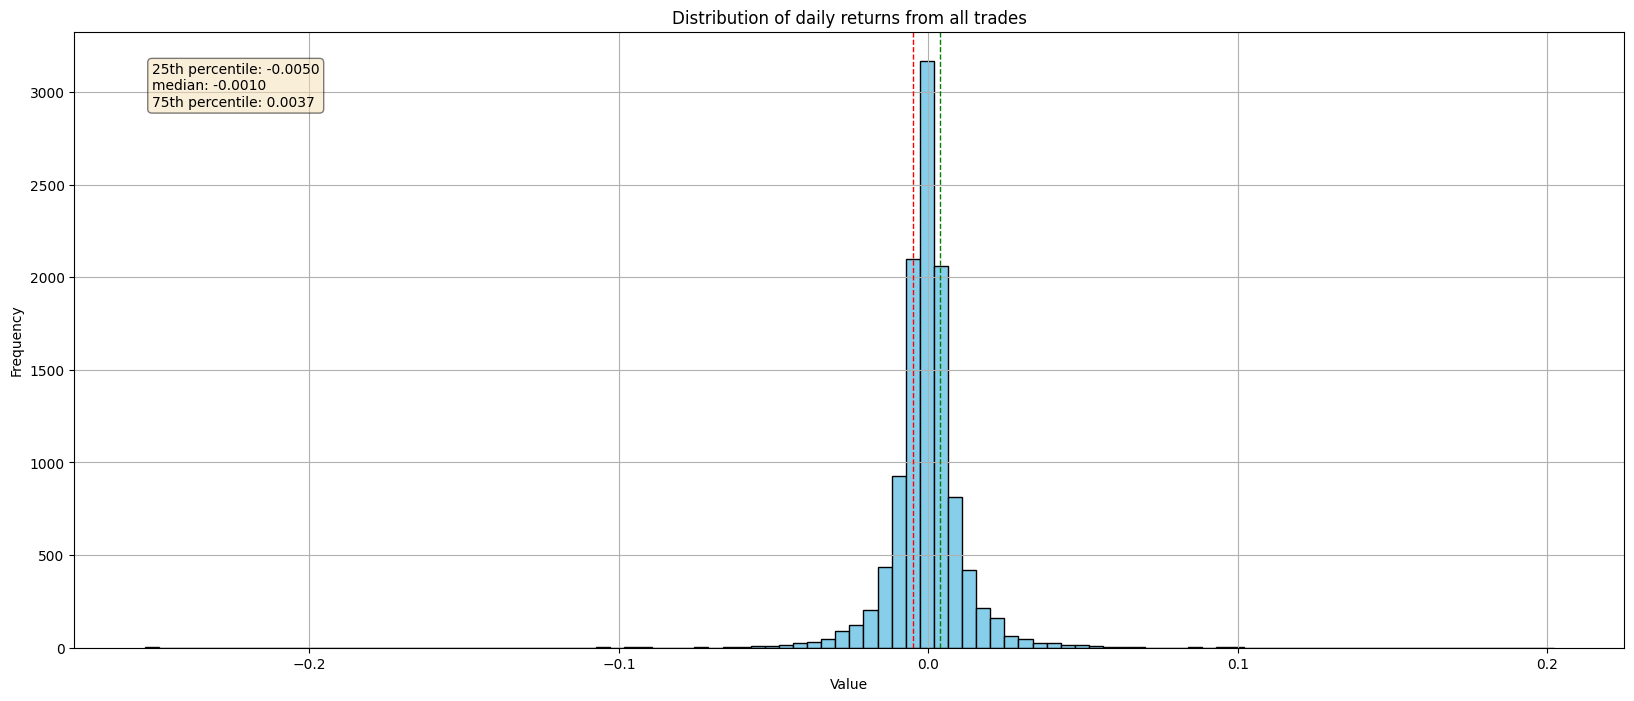

5th percentile: -0.0169


In [33]:
# violin_plot_grouped(trades_list, 'security_id', 'daily_return')
# violin_plot_grouped(trades_list.sort_values(by='duration'), 'duration', 'daily_return')
# violin_plot_grouped(trades_list, 'direction', 'daily_return', figsize=(8,5))
plot_histogram(trades_list['daily_return'], 'Distribution of daily returns from all trades', figsize=(20, 8), bins=100)
# trades_list.groupby('security_id')['daily_return'].describe()
print('5th percentile:', round(trades_list['daily_return'].quantile(0.05), 4))

In [38]:
(trades_list['position_dollar_value_open'] * trades_list['sharpe_ratio'] / trades_list['position_dollar_value_open'].sum()).sum()

104.05136604072499

<Axes: >

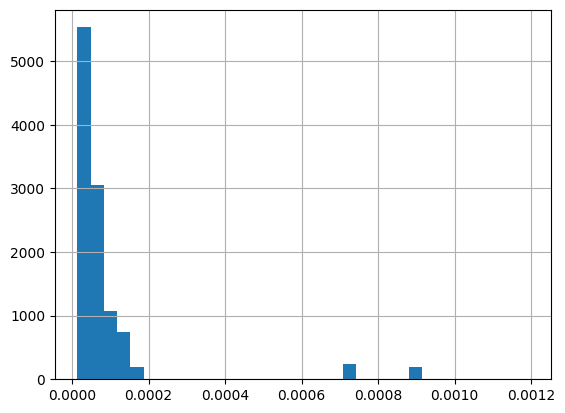

In [43]:
(trades_list['position_dollar_value_open']/trades_list['position_dollar_value_open'].sum()).hist(bins=34)

### cHeCks
using a rolling window on the price series of respectively 10, 21, 63d I compute the 5th, 15th, 25th percentiles of the distribution and I check, for the Long signal 1, if today's Price is below ALL the 5th, 15th, 25th percentiles.


In [ ]:
prova = df[['us_staples']].copy()
prova['q5_2w'] = prova['us_staples'].rolling(10).quantile(0.05)
prova['q15_1m'] = prova['us_staples'].rolling(21).quantile(0.15)
prova['q25_3m'] = prova['us_staples'].rolling(63).quantile(0.25)
prova['ma20'] = prova['us_staples'].rolling(20).mean()
prova['ma60'] = prova['us_staples'].rolling(60).mean()
prova = prova.loc['2014-02-12':].copy()

In [ ]:
prova['s1_long'] = 1 * (
    (prova['us_staples'] < prova['q5_2w']) & (prova['us_staples'] < prova['q15_1m']) & (prova['us_staples'] < prova['q25_3m']))
prova['s2_long'] = 1 * ((prova['us_staples'] < prova['ma20']) & (prova['us_staples'] < prova['ma60']))

prova['long'] = (prova['s1_long']*prova['s2_long'])

In [ ]:
signal_all[signal_all==1]

dates
2014-07-29    1
2014-07-30    1
2014-07-31    1
2014-10-15    1
2014-10-16    1
             ..
2023-10-03    1
2023-10-05    1
2023-10-06    1
2023-10-12    1
2023-10-27    1
Length: 166, dtype: int64

In [ ]:
prova[prova['s1_long']==1]['s2_long'].unique()

array([1])